In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

## Plot 2D heatmap

In [3]:
def plot_lattice(filename):
    lattice = np.loadtxt(filename)

    plt.figure(figsize=(6, 6))
    plt.imshow(lattice,
               cmap="cool",
               origin="lower",
               vmin=-1,
               vmax=1)
    plt.colorbar(label="Spin value")
    plt.title("2D Ising Lattice")
    plt.xlabel("y")
    plt.ylabel("x")
    plt.tight_layout()
    plt.show()

In [4]:
plot_lattice("data/ising_J1.000_h1.000_T100.000_Lx300_Ly300_MC0.dat")
plot_lattice("data/ising_J1.000_h1.000_T100.000_Lx300_Ly300_MC1000000.dat")

FileNotFoundError: data/ising_J1.000_h1.000_T100.000_Lx300_Ly300_MC0.dat not found.

# Data Analysi

In [10]:
import pandas as pd
from pathlib import Path

In [20]:
def load_and_merge_csv(folder_path, ignore = None):
    """
    Load all .csv files in a folder and merge them into a single DataFrame.

    Parameters
    ----------
    folder_path : str or Path
        Path to the folder containing CSV files.

    Returns
    -------
    pd.DataFrame
        Concatenated DataFrame.
    """
    folder = Path(folder_path)
    csv_files = sorted(folder.glob("*.csv"))

    if not csv_files:
        raise ValueError(f"No CSV files found in {folder}")

    if ignore is not None:
        csv_files = [f for f in csv_files if ignore not in f.name]

    dfs = [pd.read_csv(f) for f in csv_files]
    df_merged = pd.concat(dfs, ignore_index=True)

    return df_merged

In [21]:
folder = "results"
fname = "ising_results_20260131_110358.csv"

df = load_and_merge_csv(folder, fname)
df

,backend,L,init_type,J,h,T,n_steps,E,e_density,m,m_density,init_time,mh_time,mh_time_per_step
0,cpu_1,16,random,1.0,0.5,0.5,100000,-640.0,-2.500000,256.0,1.000000,0.000034,0.039713,3.971300e-07
1,cpu_1,16,random,1.0,0.5,0.5,100000,-640.0,-2.500000,256.0,1.000000,0.000029,0.039717,3.971700e-07
2,cpu_1,16,random,1.0,0.5,0.5,100000,-640.0,-2.500000,256.0,1.000000,0.000029,0.039711,3.971100e-07
3,cpu_1,16,random,1.0,0.5,0.5,100000,-640.0,-2.500000,256.0,1.000000,0.000029,0.039707,3.970700e-07
4,cpu_1,16,random,1.0,0.5,0.5,100000,-640.0,-2.500000,256.0,1.000000,0.000028,0.039706,3.970600e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11335,gpu_efficient,512,random,1.0,2.0,10.0,100000,-289812.0,-1.105545,99946.0,0.381264,0.000121,0.000107,4.081726e-10
11336,gpu_efficient,512,random,1.0,2.0,10.0,100000,-289812.0,-1.105545,99946.0,0.381264,0.000121,0.000108,4.119873e-10
11337,gpu_efficient,512,random,1.0,2.0,10.0,100000,-289812.0,-1.105545,99946.0,0.381264,0.000117,0.000108,4.119873e-10
11338,gpu_efficient,512,random,1.0,2.0,10.0,100000,-289812.0,-1.105545,99946.0,0.381264,0.000131,0.000119,4.539490e-10


Group the time results avereging on the same backend, L, init_type, J, h, T, n_steps

In [22]:
def plot_avg_performance(
    df: pd.DataFrame,
    *,
    L=None,
    T=None,
    J=None,
    h=None,
    init_type=None,
    n_steps=None,
    metric="mh_time_per_step",
    backends=("cpu_1", "cpu_openmp", "gpu", "gpu_efficient"),
    logy=True,
):
    """
    Plot average performance for selected parameters, grouped by backend.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    L, T, J, h, init_type, n_steps : optional
        If provided, filter dataframe by these values.
    metric : str
        Column to average and plot (default: 'mh_time_per_step').
    backends : tuple
        Backends to include.
    logy : bool
        Use logarithmic y-scale.
    """

    # --- filtering ---
    mask = pd.Series(True, index=df.index)

    if L is not None:
        mask &= df["L"] == L
    if T is not None:
        mask &= df["T"] == T
    if J is not None:
        mask &= df["J"] == J
    if h is not None:
        mask &= df["h"] == h
    if init_type is not None:
        mask &= df["init_type"] == init_type
    if n_steps is not None:
        mask &= df["n_steps"] == n_steps

    df_filt = df.loc[mask & df["backend"].isin(backends)]

    if df_filt.empty:
        raise ValueError("No data left after filtering.")

    # --- aggregation ---
    avg = (
        df_filt
        .groupby("backend", sort=False)[metric]
        .mean()
        .reindex(backends)
    )

    # --- plotting ---
    plt.figure(figsize=(7, 4))
    avg.plot(kind="bar")

    plt.ylabel(f"Average {metric}")
    plt.xlabel("Backend")

    title_parts = []
    for name, val in [("L", L), ("T", T), ("J", J), ("h", h), ("init", init_type)]:
        if val is not None:
            title_parts.append(f"{name}={val}")

    if title_parts:
        plt.title(", ".join(title_parts))
    else:
        plt.title("Average performance by backend")

    if logy:
        plt.yscale("log")

    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

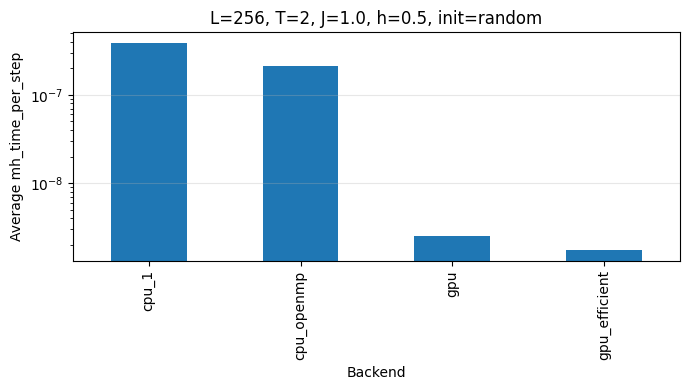

In [23]:
plot_avg_performance(
    df,
    L=256,
    T=2,
    J=1.0,
    h=0.5,
    init_type="random"
)


In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_time_vs_L(
    df: pd.DataFrame,
    *,
    T=None,
    J=None,
    h=None,
    init_type=None,
    n_steps=None,
    metric="mh_time_per_step",
    backends=("cpu_1", "cpu_openmp", "gpu", "gpu_efficient"),
    error="sem",   # "std" or "sem"
    logy=True,
):
    """
    Plot average time as a function of L with error bars, split by backend.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    T, J, h, init_type, n_steps : optional
        Fixed parameters used to filter the dataframe.
    metric : str
        Time metric to average (default: 'mh_time_per_step').
    backends : tuple
        Backends to plot.
    error : str
        Error bar type: "std" (standard deviation) or "sem" (standard error).
    logy : bool
        Use logarithmic y-scale.
    """

    # --- filtering ---
    mask = pd.Series(True, index=df.index)

    if T is not None:
        mask &= df["T"] == T
    if J is not None:
        mask &= df["J"] == J
    if h is not None:
        mask &= df["h"] == h
    if init_type is not None:
        mask &= df["init_type"] == init_type
    if n_steps is not None:
        mask &= df["n_steps"] == n_steps

    df_filt = df.loc[mask & df["backend"].isin(backends)]

    if df_filt.empty:
        raise ValueError("No data left after filtering.")

    # --- aggregation ---
    grouped = (
        df_filt
        .groupby(["backend", "L"])[metric]
        .agg(["mean", "std", "count"])
        .reset_index()
    )

    if error == "sem":
        grouped["err"] = grouped["std"] / np.sqrt(grouped["count"])
    elif error == "std":
        grouped["err"] = grouped["std"]
    else:
        raise ValueError("error must be 'std' or 'sem'")

    # --- plotting ---
    plt.figure(figsize=(7, 4))

    for backend in backends:
        sub = grouped[grouped["backend"] == backend]
        if sub.empty:
            continue

        sub = sub.sort_values("L")

        plt.errorbar(
            sub["L"],
            sub["mean"],
            yerr=sub["err"],
            marker="o",
            capsize=3,
            label=backend,
        )

    plt.xlabel("L")
    plt.ylabel(f"Average {metric}")

    title_parts = []
    for name, val in [("T", T), ("J", J), ("h", h), ("init", init_type)]:
        if val is not None:
            title_parts.append(f"{name}={val}")

    title = "Performance scaling with L"
    if title_parts:
        title += "\n" + ", ".join(title_parts)

    plt.title(title)

    if logy:
        plt.yscale("log")

    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [25]:
#list all unique L values
unique_L = df['L'].unique()
print("Unique L values in the dataset:", unique_L)

Unique L values in the dataset: [ 16  64 128 192 256 320 384 448 512]


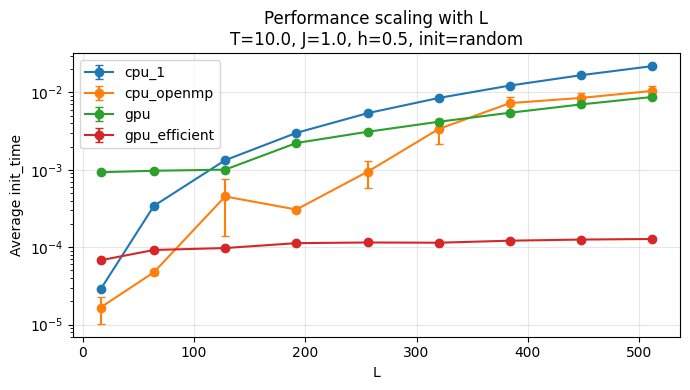

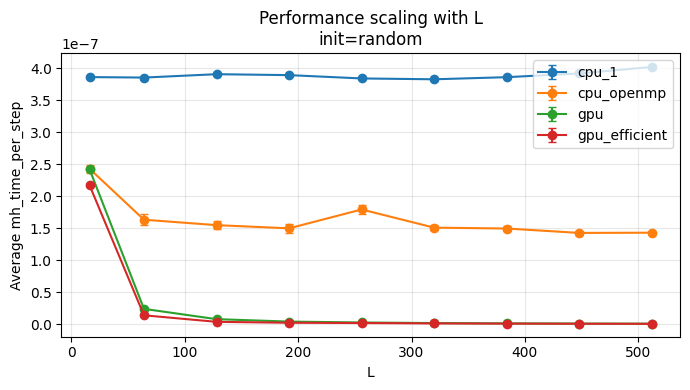

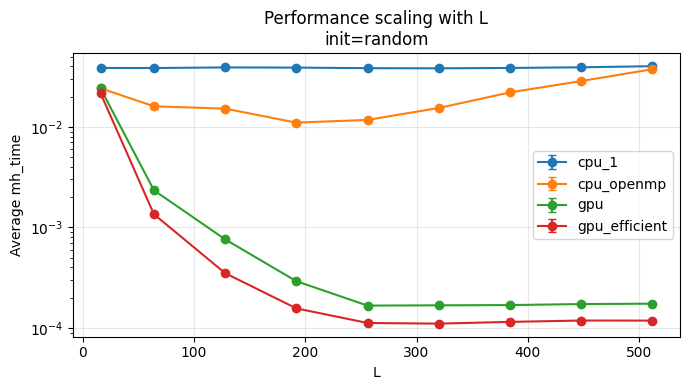

In [30]:
plot_time_vs_L(
    df,
    T=10.0,
    J=1.0,
    h=0.5,
    init_type="random",
    metric = "init_time", logy = True
)

plot_time_vs_L(
    df,
    # T=10.0,
    # J=1.0,
    # h=0.5,
    init_type="random",
    metric = "mh_time_per_step",
    logy= False
)


plot_time_vs_L(
    df,
    # T=10.0,
    # J=1.0,
    # h=0.5,
    init_type="random",
    metric = "mh_time",
    logy= True
)
